# CTC Loss with OCR

References
* https://en.wikipedia.org/wiki/Connectionist_temporal_classification
* https://keras.io/examples/vision/captcha_ocr/#model
* https://distill.pub/2017/ctc/

In [1]:
# https://jref.com/resources/ms-gothic.53/
#!wget https://jref.com/resources/ms-gothic.53/download
#!unzip msgothic.zip

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw, ImageFont, ImageOps
import tensorflow as tf
from difflib import SequenceMatcher

try:
    # Japanese language support for matplotlib.
    import japanize_matplotlib
except:
    !pip install japanize_matplotlib
    import japanize_matplotlib
    
try:
    DEVICE_NAME = tf.test.gpu_device_name()
    print("Found GPU at: {}".format(DEVICE_NAME))
except:
    DEVICE_NAME = "/device:CPU:0"
    print("ERROR: Not connected to a GPU runtime.")

Found GPU at: /device:GPU:0


In [3]:
# Make train-valid-test splits of images and labels.
N_train = 10000
N_valid = 2000
N_test = 2000

# Image dimensions.
height = 32
width = 256

# Half width katakana used in the data.
chars = "ｱｲｳｴｵｶｷｸｹｺｻｼｽｾｿﾀﾁﾂﾃﾄﾅﾆﾇﾈﾉﾊﾋﾌﾍﾎﾏﾐﾑﾒﾓﾔﾕﾖﾗﾘﾙﾚﾛﾜｦﾝ"
chars = sorted([c for c in chars])

# Character to index map and reverse map.
char_to_ind = tf.keras.layers.StringLookup(vocabulary = list(chars), mask_token = None)
ind_to_char = tf.keras.layers.StringLookup(vocabulary = char_to_ind.get_vocabulary(), mask_token = None, invert = True)

# MS Gothic font can be downloaded from: 
# https://jref.com/resources/ms-gothic.53/
font = ImageFont.truetype("./msgothic.ttc", 24)

In [4]:
def make_data(N_samples, min_len = 4, max_len = 10):
    X = []
    y = []
    # Create N_samples samples of features X and labels y.
    for i in range(N_samples):
        # Each image contains randomly generated text 
        # with random length [4, 10].
        N = np.random.randint(min_len, max_len + 1)
        text = np.random.choice(chars, N)
        text = "".join(text)
        # Randomly jitter the position of the text in the image.
        # Only the x-coordinate (i.e. the time coordinate)
        # should be jittered.
        pos = (0 + np.random.randint(0, 
                   122 + (max_len - len(text)) * 12), 5)
        image = Image.new("RGB", [width, height], (0, 0, 0))
        d = ImageDraw.Draw(image)
        d.text(pos, text, font = font, fill = (255, 255, 255), 
               anchor = "lm")
        image = ImageOps.grayscale(image)
        image = np.array(image)
        X.append(image.reshape((height, width, 1)))
        # Make all texts the same length (i.e. max_len).
        # Also ensure no white space before text.
        # These spaces will be converted to zeros by the encoder.
        text = text.strip()
        pad = (max_len - len(text)) * " "
        y.append(text + pad)
    return np.array(X), np.array(y)

X_train, y_train = make_data(N_train)
X_valid, y_valid = make_data(N_valid)
X_test, y_test = make_data(N_test)

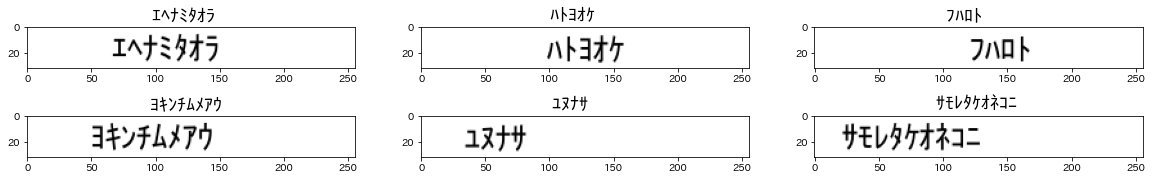

In [5]:
plt.figure(figsize = (20, 3))
for i in range(6):
    plt.subplot(2, 3, i+1)
    plt.imshow(X_train[i][:, :, 0], cmap = "binary")
    plt.title(y_train[i], fontsize = 18)
plt.show()

In [6]:
batch_size = 20
def encode_data(image, label):
    image = tf.keras.layers.Rescaling(1.0 / 255)(image)
    image = tf.transpose(image, perm = [1, 0, 2])
    label = char_to_ind(tf.strings.unicode_split(label,
                                input_encoding = "UTF-8"))
    return {"image": image, "label": label}
with tf.device(DEVICE_NAME):
    # Training data.
    train_ds = tf.data.Dataset.from_tensor_slices((X_train,
                                                   y_train))
    train_ds = train_ds.map(encode_data,
               num_parallel_calls = tf.data.AUTOTUNE)
    train_ds = train_ds.batch(batch_size)
    train_ds = train_ds.prefetch(buffer_size = tf.data.AUTOTUNE)
    # Validation data.
    valid_ds = tf.data.Dataset.from_tensor_slices((X_valid,
                                                   y_valid))
    valid_ds = valid_ds.map(encode_data,
               num_parallel_calls = tf.data.AUTOTUNE)
    valid_ds = valid_ds.batch(batch_size)
    valid_ds = valid_ds.prefetch(buffer_size = tf.data.AUTOTUNE)
    # Testing data.
    test_ds = tf.data.Dataset.from_tensor_slices((X_test,
                                                  y_test))
    test_ds = test_ds.map(encode_data,
              num_parallel_calls = tf.data.AUTOTUNE)
    test_ds = test_ds.batch(batch_size)
    test_ds = test_ds.prefetch(buffer_size = tf.data.AUTOTUNE)

In [7]:
class CTCLayer(tf.keras.layers.Layer):
    def __init__(self, name = None):
        super().__init__(name = name)
        self.loss_fn = tf.keras.backend.ctc_batch_cost

    def call(self, y_true, y_pred):
        # Number of samples in a batch.
        batch_len = tf.cast(tf.shape(y_true)[0], dtype = "int64")
        # Length of the "time steps".
        input_length = tf.cast(tf.shape(y_pred)[1], dtype = "int64")
        input_length = input_length * tf.ones(shape = (batch_len, 
                                             1), dtype = "int64")
        # Length of the label.
        label_length = tf.cast(tf.shape(y_true)[1], dtype = "int64")
        label_length = label_length * tf.ones(shape = (batch_len, 
                                             1), dtype = "int64")
        loss = self.loss_fn(y_true, y_pred, 
                input_length, label_length)
        self.add_loss(loss)
        return y_pred

In [8]:
def make_model(width, height):
    input_img = tf.keras.layers.Input(shape = (width, height, 1), 
                               name = "image", dtype = "float32")
    labels = tf.keras.layers.Input(name = "label", 
               shape = (None,), dtype = "float32")

    # CNN layers.
    x = tf.keras.layers.Conv2D(32, (3, 3), activation = "relu", 
                              kernel_initializer = "he_normal",
                                              padding = "same", 
                                     name = "Conv1")(input_img)
    x = tf.keras.layers.MaxPooling2D((2, 2), name = "pool1")(x)

    x = tf.keras.layers.Conv2D(64, (3, 3), activation = "relu", 
                              kernel_initializer = "he_normal",
                                              padding = "same", 
                                             name = "Conv2")(x)
    x = tf.keras.layers.MaxPooling2D((2, 2), name = "pool2")(x)

    # Dense layers. After 2 layers of max pooling, the width and
    # height are reduced by a factor of 4.
    new_shape = ((width // 4), (height // 4) * 64)
    x = tf.keras.layers.Reshape(target_shape = new_shape, 
                                     name = "reshape")(x)
    x = tf.keras.layers.Dense(64, 
             activation = "relu", 
              name = "dense1")(x)
    x = tf.keras.layers.Dropout(0.2)(x)

    # RNN layers.
    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, 
                                       return_sequences = True, 
                                            dropout = 0.25))(x)
    x = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(64, 
                                      return_sequences = True, 
                                           dropout = 0.25))(x)
    # Dense output layer before the CTC loss. The number of nodes
    # is the number of unique words + 1. The additional node is for
    # a special token which accounts for unknown characters.
    x = tf.keras.layers.Dense(len(char_to_ind.get_vocabulary())+1, 
                                           activation = "softmax", 
                                               name = "dense2")(x)

    # CTC loss layer.
    output = CTCLayer(name = "ctc_loss")(labels, x)

    model = tf.keras.models.Model(inputs = [input_img, labels], 
                                              outputs = output, 
                                            name = "ocr_model")
    opt = tf.keras.optimizers.Adam()
    model.compile(optimizer = opt)
    return model

In [9]:
with tf.device(DEVICE_NAME):
    model = make_model(width, height)

In [10]:
epochs = 50

history = model.fit(train_ds, epochs = epochs,
                    validation_data = valid_ds, 
                    verbose = True)

Epoch 1/50
500/500 [==============================] - 31s 43ms/step - loss: 32.1364 - val_loss: 29.2292
Epoch 2/50
500/500 [==============================] - 21s 42ms/step - loss: 29.0423 - val_loss: 28.9249
Epoch 3/50
500/500 [==============================] - 20s 40ms/step - loss: 28.8349 - val_loss: 28.7660
Epoch 4/50
500/500 [==============================] - 20s 40ms/step - loss: 28.5525 - val_loss: 28.3224
Epoch 5/50
500/500 [==============================] - 21s 42ms/step - loss: 28.1797 - val_loss: 27.9980
Epoch 6/50
500/500 [==============================] - 20s 40ms/step - loss: 27.9929 - val_loss: 27.9652
Epoch 7/50
500/500 [==============================] - 20s 40ms/step - loss: 27.7833 - val_loss: 27.6639
Epoch 8/50
500/500 [==============================] - 20s 41ms/step - loss: 27.6411 - val_loss: 27.6153
Epoch 9/50
500/500 [==============================] - 20s 40ms/step - loss: 27.2179 - val_loss: 26.8850
Epoch 10/50
500/500 [==============================] - 20s 40ms/

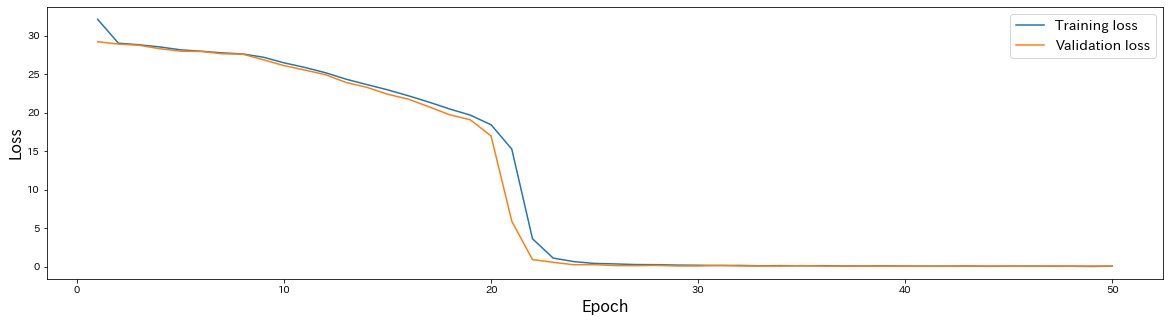

In [11]:
plt.figure(figsize = (20, 5))
plt.plot(range(1, len(history.history["loss"]) + 1),
         history.history["loss"])
plt.plot(range(1, len(history.history["val_loss"]) + 1),
         history.history["val_loss"])
plt.xlabel("Epoch", fontsize = 16)
plt.ylabel("Loss", fontsize = 16)
plt.legend(["Training loss", "Validation loss"], fontsize = 14)
plt.show()

In [13]:
def decode_batch_predictions(pred, max_len = 10):
    # input_len is the product of the batch size and the
    # number of time steps.
    input_len = np.ones(pred.shape[0]) * pred.shape[1]
    
    # Decode CTC predictions using greedy search.
    # decoded is a tuple with 2 elements.
    decoded = tf.keras.backend.ctc_decode(pred, 
                      input_length = input_len, 
                                 greedy = True)
    # The outputs are in the first element of the tuple.
    # Additionally, the first element is actually a list,
    # therefore we take the first element of that list as well.
    decoded = decoded[0][0][:, :max_len]

    output = []
    for d in decoded:
        # Convert the predicted indices to the corresponding chars.
        d = tf.strings.reduce_join(ind_to_char(d))
        d = d.numpy().decode("utf-8")
        output.append(d)
    return output
# Create the prediction model.
prediction_model = tf.keras.models.Model(
                   model.get_layer(name = "image").input, 
                   model.get_layer(name = "dense2").output)
# Predictions for the test dataset.
y_pred = []
y_true = []
for batch in test_ds:
    batch_images = batch["image"]
    batch_labels = batch["label"]
    preds = prediction_model.predict(batch_images)
    pred_texts = decode_batch_predictions(preds)
    y_pred = y_pred + pred_texts
    orig_texts = []
    for label in batch_labels:
        label = tf.strings.reduce_join(ind_to_char(label))
        label = label.numpy().decode("utf-8")
        orig_texts.append(label)
    y_true = y_true + orig_texts

In [19]:
for i in range(10):
    print("{} : {}.".format(y_true[i].strip("[UNK]"), y_pred[i].strip("[UNK]")))

ﾎﾖﾆｵﾈﾖ : ﾎﾖﾆｵﾈﾖ.
ﾐｵﾌｴﾐｸｷ : ﾐｵﾌｴﾐｸｷ.
ｦﾇﾓｽｹﾔｹﾆﾌ : ｦﾇﾓｽｹﾔｹﾆﾌ.
ｾｿｺﾄﾍﾙﾜ : ｾｿｺﾄﾍﾙﾜ.
ﾌｳﾋﾂﾔｹｹ : ﾌｳﾋﾂﾔｹｹ.
ｲﾏｼﾃｺﾜﾏｦ : ｲﾏｼﾃｺﾜﾏｦ.
ﾁﾓﾆﾄﾃﾘﾆﾈｷｸ : ﾁﾓﾆﾄﾃﾘﾆﾈｷｸ.
ｴﾚﾉﾓﾇﾒｼﾘﾒ : ｴﾚﾉﾓﾇﾒｼﾘﾒ.
ﾊﾀﾝｲﾂﾚﾕﾒ : ﾊﾀﾝｲﾂﾚﾕﾒ.
ﾕｦﾙﾖﾝﾕ : ﾕｦﾙﾖﾝﾕ.


In [15]:
def similarity(x, y):
    return SequenceMatcher(None, x, y).ratio()

similarities = np.array([0] * len(y_true))

for i in range(len(y_true)):
    similarities[i] = similarity(y_true[i], y_pred[i])
    
print(np.mean(similarities))

0.9915
